### **Code** : **PV Smart-Metering Regression Analysis_Detail_3**
- Writer : Donghyeon Kim
- Date : 2022.08.08
- Data : 태양광 사용가구 '김OO'

<hr>

### **0. Running the library and setting up the foundation**

In [1]:
# 1. 라이브러리 실행
from pathlib import Path
import os
import pandas as pd
import numpy as np 
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn import linear_model

In [2]:
# 2. 파일의 상위-상위 경로 설정
os_root = Path(os.path.join(os.getcwd(), '9. reg_analysis_detail_3.ipynb'))
root = os_root.parent.parent

In [3]:
# 3. 제작 함수 실행
from utils import get_name_root

#### **User Data : Merged with Weather and Visibility Data**

In [4]:
# 4. 사용자 데이터 호출
# Merged Data 폴더
user_folder_root = os.path.join(root, 'data_merge')

# 사용자 이름
user_name = get_name_root()

# FIXME
user = '김OO'

# 사용자 이름 index
idx = user_name.index(user)

# xlsx 파일 이름
xlsx_name = user_folder_root + '\\' + f'{user_name[idx]}_dataset_merge.xlsx'

# 데이터 호출
df_user = pd.read_excel(xlsx_name)

In [5]:
df_user.drop(['owner', 'id_hh', 'id_hs'], axis = 1).head(10)

,dt,temperature,uws_10m,vws_10m,ghi,precipitation,relative_humidity_1p5m,specific_humidity_1p5m,place,kW_type,year,month,day,hour,grid_kWh,export_kWh,yield_kWh,ym,status,visibility
0,2021-03-01 00:00:00,10.322687,0.858208,0.041718,0.000000,0.000000,60.644928,0.004421,서울,3kW,2021,3,1,0,0.200001,0.0,0.000000,2021/3,no rain,2000
1,2021-03-01 01:00:00,10.029108,0.135828,-1.085083,0.000000,0.000000,56.432068,0.004188,서울,3kW,2021,3,1,1,0.250000,0.0,0.000000,2021/3,no rain,2000
2,2021-03-01 02:00:00,9.844873,0.362611,-0.180941,0.000000,0.000000,62.081512,0.004626,서울,3kW,2021,3,1,2,0.210003,0.0,0.000000,2021/3,no rain,2000
3,2021-03-01 03:00:00,9.587915,-0.411156,0.997797,0.000000,0.000000,56.335152,0.004261,서울,3kW,2021,3,1,3,0.180000,0.0,0.000000,2021/3,no rain,2000
4,2021-03-01 04:00:00,9.564752,-0.462263,-0.222837,0.000000,0.000000,61.451012,0.004599,서울,3kW,2021,3,1,4,0.190002,0.0,0.000000,2021/3,no rain,447
5,2021-03-01 05:00:00,9.363092,0.721948,-2.010242,0.000000,0.000000,64.313083,0.004559,서울,3kW,2021,3,1,5,0.200001,0.0,0.000000,2021/3,no rain,1303
6,2021-03-01 06:00:00,8.639551,-1.163785,-1.346743,0.000000,2.439514,92.884331,0.005859,서울,3kW,2021,3,1,6,0.299999,0.0,0.000000,2021/3,rain,587
7,2021-03-01 07:00:00,8.481317,-0.673493,-1.971651,0.000000,1.226685,94.962051,0.006039,서울,3kW,2021,3,1,7,0.270000,0.0,0.000000,2021/3,rain,381
8,2021-03-01 08:00:00,8.494592,-1.207814,-0.468723,3.883789,1.170898,93.874001,0.005951,서울,3kW,2021,3,1,8,0.399998,0.0,0.000000,2021/3,rain,381
9,2021-03-01 09:00:00,8.613031,-5.542665,1.533955,18.028790,0.239624,88.038452,0.005981,서울,3kW,2021,3,1,9,0.219997,0.0,0.050003,2021/3,rain,294


<hr>

### **1. Regression Analysis**

#### 1) Observation Numbers

In [6]:
len(df_user)

10224

#### 2) Correlation Coefficient

In [7]:
d_ghi = np.ma.masked_invalid(df_user.ghi)
d_yield_kwh = np.ma.masked_invalid(df_user.yield_kWh)

round(np.ma.corrcoef(d_ghi, d_yield_kwh)[0, 1], 3)

0.881

#### 3) Simple Linear Regression
- Package : Scikit-learn
- x : GHI, y : Solar Power Generation

In [8]:
# 날짜 필터링 : 2021/4 ~ 2022/3
date_list = df_user.ym.unique().tolist()
date_list = date_list[1:-1] # 2021/3, 2022/4 제외

# 3kW 표준화
df_kw_type = df_user.kW_type.unique().tolist()[0]

if df_kw_type == '300W':
    df_user.yield_kWh = df_user.yield_kWh * 10
elif df_kw_type == '6kW':
    df_user.yield_kWh = df_user.yield_kWh / 2
elif df_kw_type == '18kW':
    df_user.yield_kWh = df_user.yield_kWh / 6

In [9]:
# SLR Result Dictionary
result = {}
result['b0'] = [] # b0(constant)
result['b1'] = [] # b1(coefficient)
result['formula'] = [] # Formula(y = b0 + b1*x)
result['r2'] = [] # R-Square(Accuracy)

for i in range(len(date_list)):
    # Year/Month Filtering
    df_user_filter = df_user[df_user.ym == date_list[i]]
    
    # Remove NAs
    x = df_user_filter.dropna(axis=0)[['ghi']]
    y = df_user_filter.dropna(axis=0)[['yield_kWh']]
    
    # Modeling #
    # Initialization
    lin_reg = linear_model.LinearRegression(fit_intercept=True)
    
    # Fitting
    lin_reg_model = lin_reg.fit(x, y)
    
    # Constant
    b0 = round(lin_reg_model.intercept_[0], 5)
    result['b0'].append(b0)
    
    # Coefficient
    b1 = round(lin_reg_model.coef_.tolist()[0][0], 5)
    result['b1'].append(b1)
    
    # Formula
    formula = f'y_hat = {b0} + {b1}*x'
    result['formula'].append(formula)
    
    # R-Square
    r2 = round(lin_reg_model.score(x, y), 3)
    result['r2'].append(r2)

##### (1) Formula(Including b0, b1)

In [10]:
result['formula']

['y_hat = 0.0186 + 0.00292*x',
 'y_hat = 0.01368 + 0.00282*x',
 'y_hat = 0.05119 + 0.00257*x',
 'y_hat = 0.04095 + 0.00212*x',
 'y_hat = 0.04507 + 0.00224*x',
 'y_hat = 0.04353 + 0.00332*x',
 'y_hat = 0.0151 + 0.00371*x',
 'y_hat = 0.01188 + 0.00355*x',
 'y_hat = -0.00336 + 0.00412*x',
 'y_hat = -0.01133 + 0.00403*x',
 'y_hat = -0.0063 + 0.00361*x',
 'y_hat = 0.00859 + 0.00317*x']

##### (2) R-Square(Accuracy)

In [11]:
result['r2']

[0.832,
 0.851,
 0.789,
 0.59,
 0.617,
 0.805,
 0.857,
 0.799,
 0.787,
 0.833,
 0.848,
 0.804]

#### 4) Result Plot

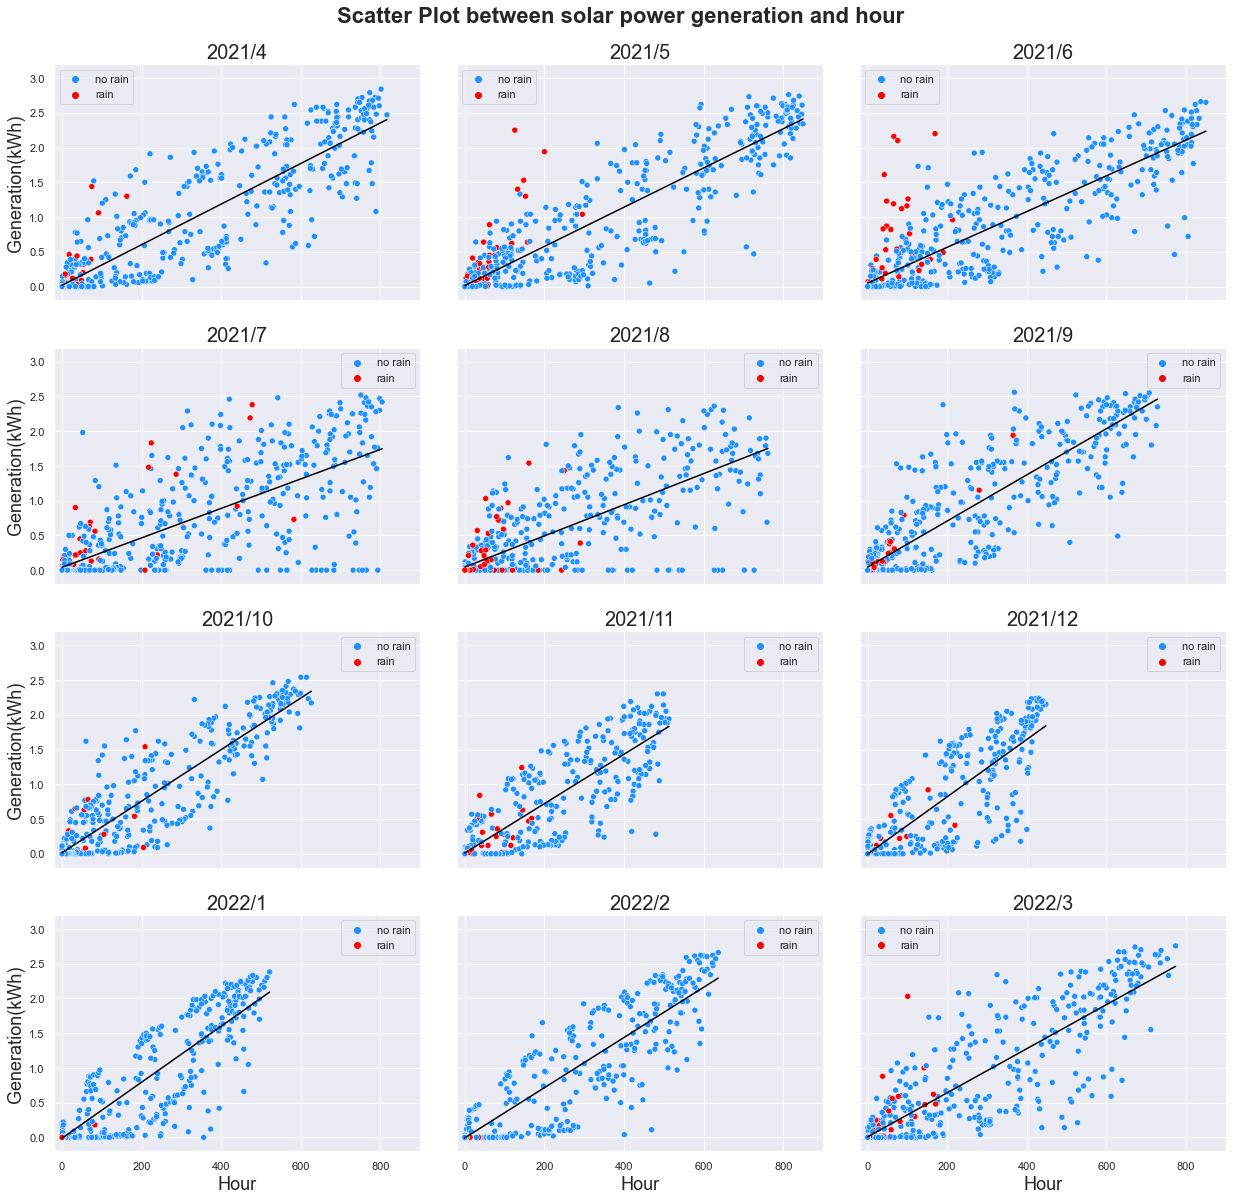

In [13]:
sns.set(rc={'figure.figsize':(21, 20)})
plt.suptitle('Scatter Plot between solar power generation and hour', y=0.92, fontsize=22, fontweight='bold')

color_dict = dict({'no rain': 'dodgerblue', 'rain': 'red'})

for i in range(len(date_list)):
    df_user_filter = df_user[df_user.ym == date_list[i]]
    y_hat = result['b0'][i] + (result['b1'][i] * df_user_filter.ghi)
    
    if i in [1, 2, 4, 5, 7, 8]: # x,y축 label 제거
        ax = plt.subplot(4, 3, i+1)
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        plt.xlim(-20.0, 900.0)
        plt.ylim(-0.2, 3.2)
        axp = sns.scatterplot(x='ghi', y='yield_kWh', hue='status', data=df_user_filter, ax=ax, palette=color_dict)
        sns.lineplot(x=df_user_filter.ghi, y=y_hat, color='black', ax=ax)
        plt.title(f'{date_list[i]}', fontsize=20)
        axp.set(xlabel=None)
        axp.set(ylabel=None)
        axp.axes.xaxis.set_ticklabels([])
        axp.axes.yaxis.set_ticklabels([])
        handles, labels = axp.get_legend_handles_labels()
        list_labels_handles = [(h, v) for h, v in zip(handles, labels)]
        list_labels_handles = sorted(list_labels_handles, key=lambda x: x[1])
        labels = [x[1] for x in list_labels_handles]
        handles = [x[0] for x in list_labels_handles]
        ax.legend(handles, labels)
    elif i in [0, 3, 6]: # x축 label만 제거
        ax = plt.subplot(4, 3, i+1)
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        plt.xlim(-20.0, 900.0)
        plt.ylim(-0.2, 3.2)
        axp = sns.scatterplot(x='ghi', y='yield_kWh', hue='status', data=df_user_filter, ax=ax, palette=color_dict)
        sns.lineplot(x=df_user_filter.ghi, y=y_hat, color='black', ax=ax)
        plt.title(f'{date_list[i]}', fontsize=20)
        axp.set(xlabel=None)
        plt.ylabel("Generation(kWh)", fontsize=18)
        axp.axes.xaxis.set_ticklabels([])
        handles, labels = axp.get_legend_handles_labels()
        list_labels_handles = [(h, v) for h, v in zip(handles, labels)]
        list_labels_handles = sorted(list_labels_handles, key=lambda x: x[1])
        labels = [x[1] for x in list_labels_handles]
        handles = [x[0] for x in list_labels_handles]
        ax.legend(handles, labels)
    elif i in [10, 11]: # y축 label만 제거
        ax = plt.subplot(4, 3, i+1)
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        plt.xlim(-20.0, 900.0)
        plt.ylim(-0.2, 3.2)
        axp = sns.scatterplot(x='ghi', y='yield_kWh', hue='status', data=df_user_filter, ax=ax, palette=color_dict)
        sns.lineplot(x=df_user_filter.ghi, y=y_hat, color='black', ax=ax)
        plt.title(f'{date_list[i]}', fontsize=20)
        plt.xlabel("Hour", fontsize=18)
        axp.set(ylabel=None)
        axp.axes.yaxis.set_ticklabels([])
        handles, labels = axp.get_legend_handles_labels()
        list_labels_handles = [(h, v) for h, v in zip(handles, labels)]
        list_labels_handles = sorted(list_labels_handles, key=lambda x: x[1])
        labels = [x[1] for x in list_labels_handles]
        handles = [x[0] for x in list_labels_handles]
        ax.legend(handles, labels)
    else:
        ax = plt.subplot(4, 3, i+1)
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        plt.xlim(-20.0, 900.0)
        plt.ylim(-0.2, 3.2)
        axp = sns.scatterplot(x='ghi', y='yield_kWh', hue='status', data=df_user_filter, ax=ax, palette=color_dict)
        sns.lineplot(x=df_user_filter.ghi, y=y_hat, color='black', ax=ax)
        plt.title(f'{date_list[i]}', fontsize=20)
        plt.xlabel("Hour", fontsize=18)
        plt.ylabel("Generation(kWh)", fontsize=18)
        handles, labels = axp.get_legend_handles_labels()
        list_labels_handles = [(h, v) for h, v in zip(handles, labels)]
        list_labels_handles = sorted(list_labels_handles, key=lambda x: x[1])
        labels = [x[1] for x in list_labels_handles]
        handles = [x[0] for x in list_labels_handles]
        ax.legend(handles, labels)

### **Appendix : All Data - Simple Linear Regression**

C:\Users\mazy4\anaconda3\envs\Energy_Analysis\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mazy4\anaconda3\envs\Energy_Analysis\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


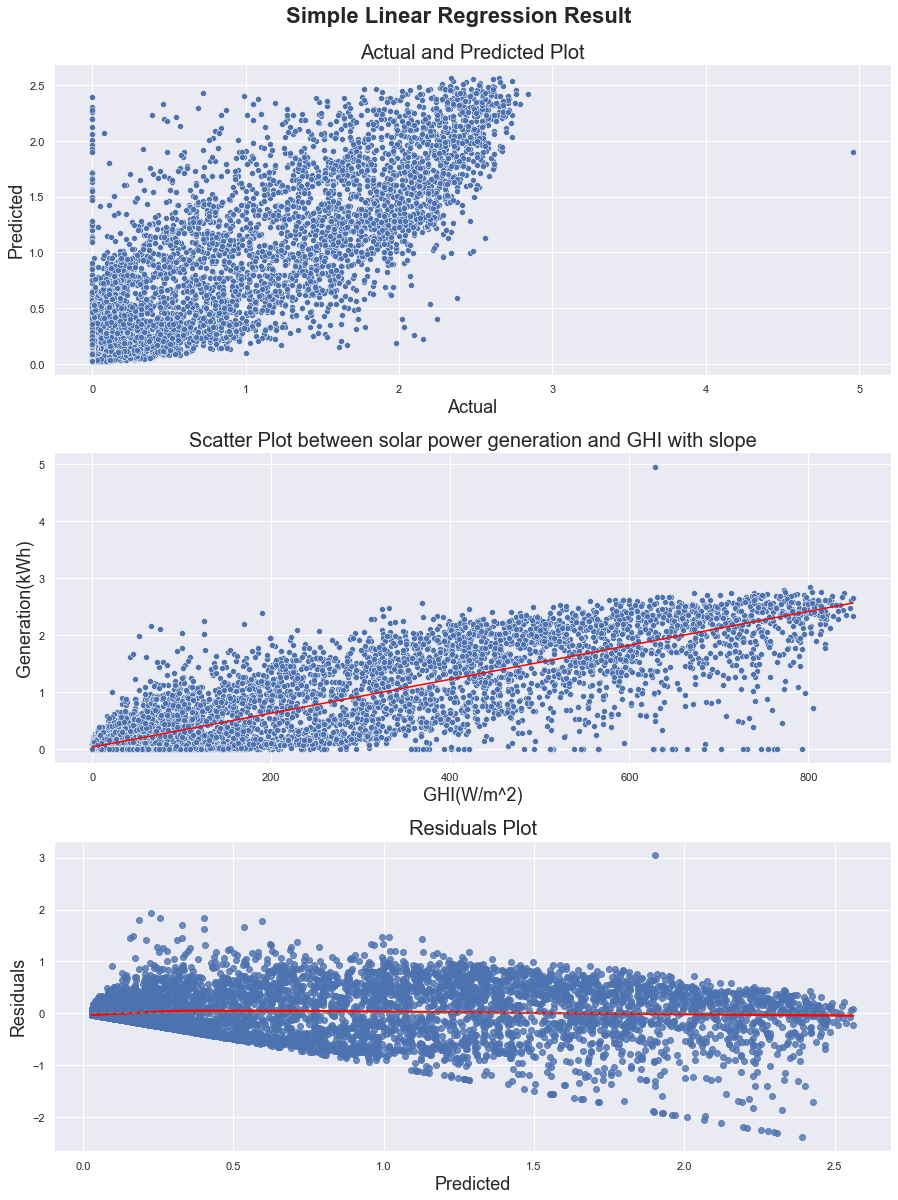

In [19]:
# # 0. Prior Setting
# fig, axes = plt.subplots(3, 1, figsize=(15, 20))
# fig.subplots_adjust(hspace=0.25)
# plt.suptitle('Simple Linear Regression Result', y=0.92, fontsize=22, fontweight='bold')

# # 1. Actual and Predicted
# y_list = y.values.flatten().tolist()
# y_pred_list = y_predict.flatten().tolist()
# sns.scatterplot(y_list, y_pred_list, ax=axes[0])
# axes[0].set_title('Actual and Predicted Plot', fontsize=20)
# axes[0].set_xlabel('Actual', fontsize=18)
# axes[0].set_ylabel('Predicted', fontsize=18)

# # 2. x, y Plot with slope
# y_hat = constant + (coef * df_user.ghi)
# p1 = sns.scatterplot(x='ghi', y='yield_kWh', data=df_user, ax=axes[1])
# p2 = sns.lineplot(x=df_user.ghi, y=y_hat, color='red', ax=axes[1])
# axes[1].set_title('Scatter Plot between solar power generation and GHI with slope', fontsize=20)
# axes[1].set_xlabel('GHI(W/m^2)', fontsize=18)
# axes[1].set_ylabel('Generation(kWh)', fontsize=18)

# # 3. Residuals Plot
# residuals = y - y_predict
# sns.regplot(y_predict, residuals, lowess=True, line_kws={'color': 'red'}, ax=axes[2])
# axes[2].plot([y_predict.min(), y_predict.max()], [0, 0], '--', color='grey')
# axes[2].set_title('Residuals Plot', fontsize=20)
# axes[2].set_xlabel('Predicted', fontsize=18)
# axes[2].set_ylabel('Residuals', fontsize=18)

# result_root = os.path.join(root, 'result_plot_use')
# if not os.path.isdir(result_root):
#     os.makedirs(result_root)

# fig_name = result_root + '/' + f'{user_name[idx]}_simple_reg_result.png'
# plt.savefig(fig_name, dpi=300, bbox_inches="tight", pad_inches=0.2)